# p2 - Underground Commuters 


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
#we are going to read the tube network from the shape file
#first, check current directory
os.getcwd()

'/Users/yingchen/Documents2/CASA/urban_simulation/practical/wk7/Week_7_final'

In [3]:
# You need to set the working directory to where you have your shapefile data
os.chdir('underground')

# Let's create a graph from the shapefile
g_shp=nx.read_shp('underground.shp',geom_attrs=False)

In [4]:
#we will need to add station names as attributes of the nodes:
nod_st1={(e1):weight for e1, e2, weight in g_shp.edges(data='station_1_')}
nod_st2={(e2):weight for e1, e2, weight in g_shp.edges(data='station_2_')}
#nod_all = {**nod_st1, **nod_st2} #for python 3.5 and greater

#In Python 2, (or 3.4 or lower) write a function
nod_all = nod_st1.copy()   # start with x's keys and values
nod_all.update(nod_st2)

nx.set_node_attributes(g_shp,nod_all,'station')

# get the nodes attributes:
#list(g_shp.nodes(data=True))[0:10]

In [5]:
#do we want this graph to be a directed one? In fact, only a few links in the dataset are directed

# We can transform the type of graph from directed to undirected using the following function:
g_shp_un = g_shp.to_undirected()

#Finally, we will give an ID to each node(station), such that it will be easier later to call them:
#1.Create a new attribute with node coordinates (now coord are the keys and we do not want to lose that information
nod_coord = {(e1):e1 for e1 in g_shp_un.nodes()}
nx.set_node_attributes(g_shp_un,nod_coord,'station_coord')
list(g_shp_un.nodes(data=True))[0]


((-0.1571, 51.5226),
 {'station': 'Baker Street', 'station_coord': (-0.1571, 51.5226)})

In [6]:
#2.now relabel each node with an ordered integer:
node_list = list(g_shp_un.nodes())
mapping = {node_list[i]:i for i in range(len(node_list))}
g_shp_un = nx.relabel_nodes(g_shp_un, mapping)
list(g_shp_un.nodes(data=True))[0]

(0, {'station': 'Baker Street', 'station_coord': (-0.1571, 51.5226)})

In [7]:
#Later when using the Commuters data we will have an issue mapping node 'Heathrow Terminals 1, 2 & 3', 
#so we are going to rename it here:
#1. find the node 'Heathrow Terminals 1, 2 & 3'
nodes = [(x,y) for x,y in g_shp_un.nodes(data='station') if 'Heathrow' in str(y)]
nodes

[(258, 'Heathrow Terminals 1, 2 & 3'), (259, 'Heathrow Terminal 4')]

In [8]:
#2.Rename it with the name given by the the commuters file (see later):
g_shp_un.nodes[258]['station']='Heathrow Terminals 123'

## Commuters flows in the tube network

We are going to create the flows of commuters travelling between any pair of tube stations

In [9]:
import pandas as pd
#First, we read the csv file with commuting flows starting and ending between stations, called Origin-Destination:
#Check you are in the correct directory to read the csv 
os.getcwd()

'/Users/yingchen/Documents2/CASA/urban_simulation/practical/wk7/Week_7_final/underground'

In [10]:
os.chdir('..')
os.getcwd()

'/Users/yingchen/Documents2/CASA/urban_simulation/practical/wk7/Week_7_final'

In [11]:
# Read Origin-Destination table from the csv
orig_dest = pd.read_csv('ODtube2017.csv')
orig_dest.head()

,From,station_name,To,station_name.1,total_wtrips
0,500,Acton Town,505,Alperton,143
1,500,Acton Town,506,Amersham,22
2,500,Acton Town,507,Angel,15
3,500,Acton Town,508,Archway,9
4,500,Acton Town,510,Arsenal,9


In [12]:
#This can be seen as a network by itself:
g_OD = nx.from_pandas_edgelist(orig_dest, 'station_name', 'station_name.1',['total_wtrips'],create_using=nx.MultiDiGraph)

In [13]:
#Change the names of nodes by the id in g_shp_un (tube network):

#1.Copy name as an attribute:
nod_names={(e1):e1 for e1 in g_OD.nodes()}
nx.set_node_attributes(g_OD,nod_names,'station') #with nod_id1 or nod_id2 is enought
print(list(g_OD.nodes(data=True))[:10])

[('Acton Town', {'station': 'Acton Town'}), ('Alperton', {'station': 'Alperton'}), ('Amersham', {'station': 'Amersham'}), ('Angel', {'station': 'Angel'}), ('Archway', {'station': 'Archway'}), ('Arsenal', {'station': 'Arsenal'}), ('Baker Street', {'station': 'Baker Street'}), ('Bank', {'station': 'Bank'}), ('Barbican', {'station': 'Barbican'}), ('Barons Court', {'station': 'Barons Court'})]


In [14]:
#2.Do the mapping with id in g_shp_un
mapping = {g_shp_un.nodes[i]['station']:i for i in g_shp_un.nodes()}
g_OD = nx.relabel_nodes(g_OD, mapping)
print(list(g_OD.nodes(data=True))[:10])

[(111, {'station': 'Acton Town'}), (238, {'station': 'Alperton'}), (172, {'station': 'Amersham'}), (196, {'station': 'Angel'}), (198, {'station': 'Archway'}), (244, {'station': 'Arsenal'}), (0, {'station': 'Baker Street'}), (25, {'station': 'Bank'}), (77, {'station': 'Barbican'}), (100, {'station': 'Barons Court'})]


In [15]:
#and we can add coordinates to the nodes, from the shapefile of the tube network:
nod_coords={(e1):coord for e1, coord in g_shp_un.nodes(data='station_coord')}

nx.set_node_attributes(g_OD,nod_coords,'station_coord') #with nod_id1 or nod_id2 is enought

pos = {e1: xy for e1,xy in g_OD.nodes(data='station_coord')}


In [16]:
#Even if we have not considered the weights (we will later on), 
#this network does not represent the commuting flows, what is happening?

#From the Origin Destination network, we need to compute the number of commuters for each pair of stations:
#How will we know the path of commuters from their origin to their destinations? 
#Given that the tube network is undirected and that we do not have information on the different tube lines, 
#we will assume that commuters use the shortest path between Origin and Destination

In [17]:
#Now, let's create the network with the actual flow of commuters travelling between each pair of stations,
#regardless which was their origin and destination:

#We will create that graph using the adjacency matrix method that was presented in previous practicals:
#First we create an empty adjacency matrix:
N=len(g_shp_un.nodes()) #As we are going to use shortest path in the tube network, N is from g_shp_un
adj_c=np.zeros((N, N))

#Fill the adjacency matrix with Origin-Destination flows:
#From origin to destination with x commuters, we will compute the shortest path and fill the number of commuters
#for each pair of stations they go through:
for e1,e2,C in g_OD.edges(data='total_wtrips'):
    path = nx.dijkstra_path(g_shp_un,e1,e2,'distance')  #shortest path e1,e2 taking into account distance weights in g_shp_un
    path_edges = list(zip(path,path[1:])) #list of tuples with shortest path edges [(e1,s2),(s3,s4),...,(s(n-1),e2)]
    for (s1,s2) in path_edges:
            adj_c[s1,s2]=adj_c[s1,s2]+C #sum the contribution of the OD flow to all edges in the shortest path
adj_c

array([[     0.,  96682.,   1560., ...,      0.,      0.,      0.],
       [102485.,      0.,      0., ...,      0.,      0.,      0.],
       [  1167.,      0.,      0., ...,      0.,      0.,      0.],
       ...,
       [     0.,      0.,      0., ...,      0.,  34817.,      0.],
       [     0.,      0.,      0., ...,  37111.,      0.,      0.],
       [     0.,      0.,      0., ...,      0.,      0.,      0.]])

In [18]:
#Create the new graph from the adjancency matrix:
g_flows=nx.from_numpy_matrix(adj_c, create_using=nx.DiGraph)


In [19]:
#we need to give coordinates to these nodes too:
nod_coord = {(e1):coord for e1,coord in g_shp_un.nodes(data='station_coord')}
nx.set_node_attributes(g_flows,nod_coord,'station_coord')
list(g_flows.nodes(data=True))[0:10]

[(0, {'station_coord': (-0.1571, 51.5226)}),
 (1, {'station_coord': (-0.1631, 51.5225)}),
 (2, {'station_coord': (-0.1466, 51.5234)}),
 (3, {'station_coord': (-0.1247, 51.508)}),
 (4, {'station_coord': (-0.1223, 51.5074)}),
 (5, {'station_coord': (-0.1342, 51.5098)}),
 (6, {'station_coord': (-0.1679, 51.5199)}),
 (7, {'station_coord': (-0.1755, 51.5154)}),
 (8, {'station_coord': (-0.1001, 51.4943)}),
 (9, {'station_coord': (-0.1115, 51.4991)})]

In [20]:
#also the station names:
nod_names = {(e1):name for e1,name in g_shp_un.nodes(data='station')}
nx.set_node_attributes(g_flows,nod_names,'station')
list(g_flows.nodes(data=True))[0:10]

[(0, {'station_coord': (-0.1571, 51.5226), 'station': 'Baker Street'}),
 (1, {'station_coord': (-0.1631, 51.5225), 'station': 'Marylebone'}),
 (2, {'station_coord': (-0.1466, 51.5234), 'station': "Regent's Park"}),
 (3, {'station_coord': (-0.1247, 51.508), 'station': 'Charing Cross'}),
 (4, {'station_coord': (-0.1223, 51.5074), 'station': 'Embankment'}),
 (5, {'station_coord': (-0.1342, 51.5098), 'station': 'Picadilly Circus'}),
 (6, {'station_coord': (-0.1679, 51.5199), 'station': 'Edgware Road (B)'}),
 (7, {'station_coord': (-0.1755, 51.5154), 'station': 'Paddington'}),
 (8, {'station_coord': (-0.1001, 51.4943), 'station': 'Elephant & Castle'}),
 (9, {'station_coord': (-0.1115, 51.4991), 'station': 'Lambeth North'})]

## Betweenness Centrality

Let's explore the commuting flows network with some exercises on different type of centrality measures and disruptions on the network. Keep in mind that this network is a directed network and nodes and edges centrality depends on the direction of the flows.

In [21]:
# invert commuters
v_weights={(e1, e2):round(1./weight,5) for e1, e2, weight in g_flows.edges(data='weight')}
nx.set_edge_attributes(g_flows, v_weights, 'v_weights')

In [22]:
# betweenness centrality for directed commuting flows:
bet_london_w=nx.betweenness_centrality(g_flows, weight='v_weights', normalized=False)
# We can add these values to the nodes attributes:
nx.set_node_attributes(g_flows,bet_london_w,'betweenness_flows')

In [23]:
# top 10 nodes with highest centrality values
dict_bet_flows=dict(g_flows.nodes(data=True))
from collections import OrderedDict
listbet_flows=OrderedDict(sorted(dict_bet_flows.items(), key=lambda x: x[1]['betweenness_flows'],reverse=True))
list(listbet_flows.items())[:10]

[(0,
  {'station_coord': (-0.1571, 51.5226),
   'station': 'Baker Street',
   'betweenness_flows': 27764.933333333338}),
 (24,
  {'station_coord': (-0.1415, 51.515),
   'station': 'Oxford Circus',
   'betweenness_flows': 26128.166666666664}),
 (88,
  {'station_coord': (-0.1238, 51.5308),
   'station': "King's Cross St. Pancras",
   'betweenness_flows': 22304.59999999997}),
 (26,
  {'station_coord': (-0.0823, 51.5178),
   'station': 'Liverpool Street',
   'betweenness_flows': 21683.4}),
 (95,
  {'station_coord': (-0.0726, 51.5154),
   'station': 'Aldgate East',
   'betweenness_flows': 20659.9}),
 (33,
  {'station_coord': (-0.1494, 51.5142),
   'station': 'Bond Street',
   'betweenness_flows': 20283.700000000023}),
 (96,
  {'station_coord': (-0.0612, 51.5194),
   'station': 'Whitechapel',
   'betweenness_flows': 19466.9}),
 (131,
  {'station_coord': (-0.047, 51.5221),
   'station': 'Stepney Green',
   'betweenness_flows': 19084.4}),
 (32,
  {'station_coord': (-0.0332, 51.5249),
   'stati

In [24]:
# just the station names
BC=pd.DataFrame.from_dict(bet_london_w,columns=['betweenness_flows'],orient='index')
maxbet10=BC.sort_values(by=['betweenness_flows'],ascending=False)[:10]
maxbet10 = maxbet10.index.tolist()
for i in maxbet10:
    print(g_flows.nodes[i]['station'])

Baker Street
Oxford Circus
King's Cross St. Pancras
Liverpool Street
Aldgate East
Bond Street
Whitechapel
Stepney Green
Mile End
Earl's Court


In [25]:
# 2. on edges
bet_london_e=nx.edge_betweenness_centrality(g_flows, normalized=False, weight='v_weights')
nx.set_edge_attributes(g_flows,bet_london_e,'betweenness_edge')

In [26]:
list(bet_london_e.items())[:3]

[((0, 1), 5022.0), ((0, 2), 0.0), ((0, 33), 7520.433333333327)]

### Analysis

In [27]:
##################################################################################

In [28]:
BC = nx.betweenness_centrality(g_flows,weight='v_weights', normalized=False)
BC_sort = sorted(BC.items(), key=lambda x:-x[-1])

In [29]:
def remove_node(G,dicts):
    nodes = [k for k,v in dicts]
    n = len(nodes)
    res1 = [] # 连通子图
    res3 = []
    res1.append(1)
    res3.append(0)
    label = 0
    while label < n:
        G.remove_node(nodes[label])
        label += 1
        nums = [len(c) for c in sorted(nx.strongly_connected_components(G), key=len, reverse=True)]
        if len(nums):
            res1.append(nums[0]/n)
        else:
            res1.append(0)
        res3.append((label+1)/n)

    return res1,res3

In [30]:
count = 0
n = len(g_flows.nodes())
resBC = []
resBC.append(1)
while count < n:
    BC = nx.betweenness_centrality(g_flows,weight='v_weights', normalized=False)
    BC_sort = sorted(BC.items(),key=lambda x:-x[-1])
    g_flows.remove_node(BC_sort[0][0])
    nums = [len(c) for c in sorted(nx.strongly_connected_components(g_flows), key=len, reverse=True)]
    if len(nums):
        resBC.append(nums[0]/n)
    else:
        resBC.append(0)
    count += 1
print('BC')

BC


In [31]:
resBC

[1,
 0.9052287581699346,
 0.8758169934640523,
 0.869281045751634,
 0.5326797385620915,
 0.5294117647058824,
 0.46405228758169936,
 0.46078431372549017,
 0.41830065359477125,
 0.3333333333333333,
 0.2222222222222222,
 0.19281045751633988,
 0.14705882352941177,
 0.14705882352941177,
 0.12418300653594772,
 0.1111111111111111,
 0.09477124183006536,
 0.0784313725490196,
 0.06535947712418301,
 0.06535947712418301,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.049019607843137254,
 0.0457516339869281,
 0.0457516339869281,
 0.0457516339869281,
 0.0457516339869281,
 0.042483660130718956,
 0.042483660130718956,
 0.042483660130718956,
 0.0392156862745098,
 0.0392156862745098,
 0.03594771241830065,
 0.029411764705882353,
 0.029411764705882353,
 0.029411764705882353,
 0.026143790849673203,
 0.026143790849673203,
 0.026143790849673203,
 0.026143790849673203,
 0.026143790849673203,
 0.026143790849673203,
 0.02287581699346405,
 0.02287581699346405,
 0.01

In [32]:
resDC = [1,
 0.9052287581699346,
 0.8398692810457516,
 0.8366013071895425,
 0.8300653594771242,
 0.8006535947712419,
 0.7450980392156863,
 0.7418300653594772,
 0.6928104575163399,
 0.6895424836601307,
 0.6699346405228758,
 0.6633986928104575,
 0.6503267973856209,
 0.40522875816993464,
 0.3562091503267974,
 0.3562091503267974,
 0.2875816993464052,
 0.2647058823529412,
 0.22875816993464052,
 0.22875816993464052,
 0.1830065359477124,
 0.1830065359477124,
 0.1830065359477124,
 0.1830065359477124,
 0.1437908496732026,
 0.1437908496732026,
 0.1437908496732026,
 0.1437908496732026,
 0.1437908496732026,
 0.1437908496732026,
 0.1437908496732026,
 0.10457516339869281,
 0.10457516339869281,
 0.10457516339869281,
 0.09477124183006536,
 0.0784313725490196,
 0.042483660130718956,
 0.042483660130718956,
 0.042483660130718956,
 0.042483660130718956,
 0.0392156862745098,
 0.0392156862745098,
 0.0392156862745098,
 0.0392156862745098,
 0.0392156862745098,
 0.0392156862745098,
 0.0392156862745098,
 0.0392156862745098,
 0.0392156862745098,
 0.0392156862745098,
 0.0392156862745098,
 0.0392156862745098,
 0.0392156862745098,
 0.0392156862745098,
 0.0392156862745098,
 0.0392156862745098,
 0.0392156862745098,
 0.0392156862745098,
 0.0392156862745098,
 0.0392156862745098,
 0.03594771241830065,
 0.03594771241830065,
 0.03594771241830065,
 0.03594771241830065,
 0.03594771241830065,
 0.03594771241830065,
 0.03594771241830065,
 0.03594771241830065,
 0.03594771241830065,
 0.029411764705882353,
 0.029411764705882353,
 0.029411764705882353,
 0.029411764705882353,
 0.029411764705882353,
 0.029411764705882353,
 0.029411764705882353,
 0.029411764705882353,
 0.029411764705882353,
 0.029411764705882353,
 0.029411764705882353,
 0.029411764705882353,
 0.029411764705882353,
 0.029411764705882353,
 0.029411764705882353,
 0.026143790849673203,
 0.026143790849673203,
 0.026143790849673203,
 0.026143790849673203,
 0.026143790849673203,
 0.026143790849673203,
 0.026143790849673203,
 0.026143790849673203,
 0.026143790849673203,
 0.02287581699346405,
 0.02287581699346405,
 0.013071895424836602,
 0.013071895424836602,
 0.013071895424836602,
 0.013071895424836602,
 0.013071895424836602,
 0.013071895424836602,
 0.013071895424836602,
 0.013071895424836602,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0]

In [33]:
resCC = [1,
 0.9052287581699346,
 0.8986928104575164,
 0.8954248366013072,
 0.8921568627450981,
 0.49019607843137253,
 0.4869281045751634,
 0.48366013071895425,
 0.39869281045751637,
 0.39869281045751637,
 0.39869281045751637,
 0.3954248366013072,
 0.3954248366013072,
 0.3954248366013072,
 0.3954248366013072,
 0.3954248366013072,
 0.3954248366013072,
 0.20261437908496732,
 0.20261437908496732,
 0.20261437908496732,
 0.20261437908496732,
 0.20261437908496732,
 0.20261437908496732,
 0.20261437908496732,
 0.20261437908496732,
 0.20261437908496732,
 0.20261437908496732,
 0.20261437908496732,
 0.20261437908496732,
 0.20261437908496732,
 0.20261437908496732,
 0.10784313725490197,
 0.10784313725490197,
 0.10784313725490197,
 0.10784313725490197,
 0.10784313725490197,
 0.10784313725490197,
 0.10784313725490197,
 0.10784313725490197,
 0.10457516339869281,
 0.10457516339869281,
 0.10457516339869281,
 0.10457516339869281,
 0.10457516339869281,
 0.10457516339869281,
 0.10457516339869281,
 0.10457516339869281,
 0.10457516339869281,
 0.10457516339869281,
 0.10457516339869281,
 0.10457516339869281,
 0.10457516339869281,
 0.10457516339869281,
 0.10457516339869281,
 0.10457516339869281,
 0.10457516339869281,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.032679738562091505,
 0.032679738562091505,
 0.032679738562091505,
 0.032679738562091505,
 0.032679738562091505,
 0.016339869281045753,
 0.016339869281045753,
 0.016339869281045753,
 0.016339869281045753,
 0.016339869281045753,
 0.016339869281045753,
 0.016339869281045753,
 0.016339869281045753,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.006535947712418301,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0.0032679738562091504,
 0]

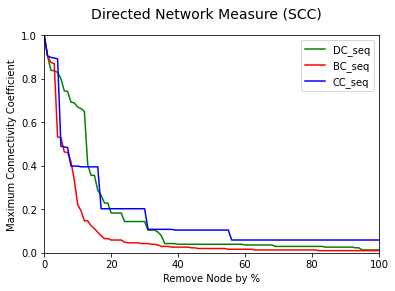

<Figure size 432x288 with 0 Axes>

In [43]:
fig = plt.figure()
fig.suptitle('Directed Network Measure (SCC)', fontsize=14)
plt.plot(resDC, color='g',label='DC_seq')
plt.plot(resBC, color='r',label='BC_seq')
plt.plot(resCC, color='b',label='CC_seq')


plt.legend(loc='upper right', fontsize = 10)

plt.xlim(0,100)
plt.ylim(0,1)

plt.xlabel('Remove Node by %', fontsize = 10)
plt.ylabel('Maximum Connectivity Coefficient', fontsize = 10)

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('p2_impact.png', dpi=100)